# Model 3
## Run XGBoost without any location data, compute averaged neighborhood residuals and then cluster based on these residuals

In [33]:
import pandas as pd 
import numpy as np
import sklearn as sk
import random
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [34]:
pd.set_option('display.max_columns', None)

# Load the dfs
train_df = pd.read_csv('train_processed.csv')
test_df = pd.read_csv('test_processed.csv')

# Find the lengths of the train and test dataframes
train_size = len(train_df)
test_size = len(test_df)

# Drop the latitude and longitude columns
lat_column = train_df['latitude']
long_column = train_df['longitude']

train_df = train_df.drop(columns=['latitude', 'longitude'])

train_df

,price,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,accommodates,bathrooms,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,Air conditioning,Kitchen,Dedicated workspace,Heating,Hot water,Refrigerator,Free street parking,Self check-in,Shampoo,Washer
0,4,16578,2.0,100.0,100.0,1,2.0,2.0,1,1,1,4,2.0,2.0,2.0,1,12,42,70,70,False,30,1125,34,5,1,18014,19945,5.000000,5.000000,4.970000,5.00000,5.000000,4.710000,4.940000,0.520000,1,0,0,0,0,1,0,1,1,1,1,1,1,0
1,3,19614,1.0,100.0,98.0,1,1.0,1.0,1,1,1,2,1.0,1.0,2.0,1,10,20,49,324,False,1,29,30,30,6,19735,19968,4.830000,4.870000,4.930000,4.80000,4.900000,4.900000,4.630000,3.810000,0,0,1,0,1,1,0,0,1,0,1,1,1,0
2,3,19204,1.0,100.0,100.0,0,52.0,55.0,1,1,52,2,1.0,0.0,1.0,1,17,44,70,146,True,1,29,5,5,2,19901,19952,4.600000,4.800000,4.200000,4.80000,4.800000,4.800000,4.200000,2.140000,1,0,0,0,1,0,1,1,1,0,0,1,1,0
3,0,15563,1.0,99.0,23.0,0,727.0,1336.0,1,1,719,1,1.5,4.0,1.0,1,0,0,0,111,False,30,365,0,0,0,20049,20049,4.719393,4.742812,4.679642,4.82631,4.808233,4.721844,4.609505,1.245801,0,0,1,0,0,1,1,1,1,1,0,0,0,1
4,2,16427,1.0,93.0,95.0,0,707.0,2453.0,1,1,73,2,1.0,1.0,1.0,1,4,13,22,241,True,1,1125,0,0,0,20049,20049,4.719393,4.742812,4.679642,4.82631,4.808233,4.721844,4.609505,1.245801,0,1,0,0,1,0,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15691,5,18866,1.0,99.0,99.0,1,15.0,15.0,1,1,15,4,1.0,1.0,4.0,1,6,12,22,139,True,1,365,32,13,1,19372,19949,4.940000,4.940000,4.910000,4.97000,4.810000,5.000000,4.720000,1.600000,1,0,0,0,1,0,1,1,1,1,0,1,1,0
15692,0,17734,1.0,100.0,67.0,0,2.0,2.0,1,1,2,2,1.0,1.0,1.0,1,0,0,0,216,False,30,1125,6,2,0,19463,19679,4.330000,4.330000,4.170000,4.17000,4.330000,4.000000,4.330000,0.350000,0,0,1,0,0,1,1,0,1,1,1,1,1,0
15693,5,17596,1.0,100.0,98.0,1,28.0,35.0,1,1,16,3,1.0,1.0,1.0,1,24,27,57,331,True,1,365,1,0,0,19590,19590,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,0.080000,0,0,1,0,1,1,0,1,0,0,0,1,1,0
15694,5,17151,1.0,100.0,96.0,0,4494.0,4784.0,1,1,876,2,1.0,1.0,1.0,1,0,0,0,247,False,31,1125,0,0,0,20049,20049,4.719393,4.742812,4.679642,4.82631,4.808233,4.721844,4.609505,1.245801,1,0,0,0,1,1,0,1,1,1,0,1,1,0


## Train XGBoost without the location data

In [35]:
# Split features and target
X = train_df.drop(columns=['price'])
y = train_df['price']

# Set up parameter grid for grid search
param_grid = {
    'n_estimators': [100, 500, 1000, 1500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 7, 10, 15],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Define the XGBoost Regressor
xgb_model = xgb.XGBRegressor()

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # Using neg_mean_squared_error for RMSE calculation
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X, y)

# Retrieve the best parameters and model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Compute the best average RMSE
best_avg_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best Average RMSE over folds: {best_avg_rmse:.4f}")

# Train the model with the best parameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X, y)

# Predict on the same data
y_pred = best_model.predict(X)

# Compute the differences
price_diff = y - y_pred

# Create a DataFrame with location columns, actual prices, predicted prices, and differences
surprise_df = pd.DataFrame({
    'latitude': lat_column,
    'longitude': long_column,
    'price_difference': price_diff
})

surprise_df


Fitting 5 folds for each of 192 candidates, totalling 960 fits


/opt/anaconda3/envs/671/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1500, 'subsample': 0.8}
Best Average RMSE over folds: 0.8285


,latitude,longitude,price_difference
0,40.684560,-73.939870,0.081423
1,40.638991,-73.965739,0.047657
2,40.618810,-74.032380,-0.052605
3,40.673970,-73.953990,-0.035475
4,40.747180,-73.985390,-0.150916
...,...,...,...
15691,40.704777,-74.006425,-0.010690
15692,40.881490,-73.910130,-0.111266
15693,40.765440,-73.976508,0.113807
15694,40.735635,-74.005740,0.073095


# KNN to find average surprise of neighbor properties

In [38]:
def knn(surprise_df, k1):

    # Extract longitude and latitude for KNN
    coordinates = surprise_df[['longitude', 'latitude']].values

    # Initialize the KNN model (for k1 neighbors)
    knn = NearestNeighbors(n_neighbors=k1)

    # Fit the KNN model
    knn.fit(coordinates)

    # Find the k1 nearest neighbors for each property
    distances, indices = knn.kneighbors(coordinates)

    # Initialize an array to store the averaged price differences
    average_price_differences = np.zeros(surprise_df.shape[0])

    # For each property, calculate the average price difference of its k1 nearest neighbors
    for i in range(surprise_df.shape[0]):
        # Get the indices of the neighbors (including the property itself)
        neighbor_indices = indices[i]
        
        # Extract the price differences for the neighbors
        neighbor_price_differences = surprise_df.iloc[neighbor_indices]['price_difference']
        
        # Compute the average price difference of the neighbors
        average_price_differences[i] = neighbor_price_differences.mean()

    # Append the column to surprise_df
    surprise_df['average_neighbor_price_difference'] = average_price_differences

    return surprise_df

# Examples
surprise0_df = knn(surprise_df, 500)

surprise0_df

,latitude,longitude,price_difference,average_neighbor_price_difference
0,40.684560,-73.939870,0.081423,-0.005654
1,40.638991,-73.965739,0.047657,-0.057846
2,40.618810,-74.032380,-0.052605,-0.039686
3,40.673970,-73.953990,-0.035475,-0.001779
4,40.747180,-73.985390,-0.150916,0.028033
...,...,...,...,...
15691,40.704777,-74.006425,-0.010690,0.044174
15692,40.881490,-73.910130,-0.111266,-0.066673
15693,40.765440,-73.976508,0.113807,0.052566
15694,40.735635,-74.005740,0.073095,0.109589


## K Means to find clusters with similar amounts of surprise (price difference)

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_88848/2310280613.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', k2)  # Use the 'tab20' colormap with k2 distinct colors


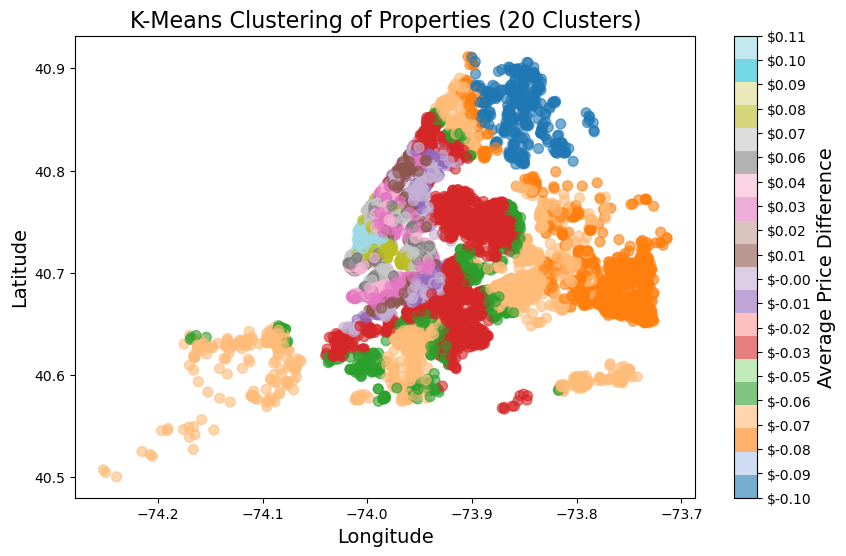

In [39]:
def k_means(k2, surprise_df):
    # Apply KMeans clustering on the averaged price difference
    kmeans = KMeans(n_clusters=k2, random_state=42)
    surprise_df['cluster'] = kmeans.fit_predict(surprise_df[['average_neighbor_price_difference']])  # Use only the averaged price difference

    # Compute the average price difference for each cluster
    cluster_means = surprise_df.groupby('cluster')['price_difference'].mean()
    
    # Map the cluster average back to each row in the DataFrame
    surprise_df['cluster_avg_price_difference'] = surprise_df['cluster'].map(cluster_means)

    return surprise_df

def plot_cluster(df, k2):
    # Plot the clusters and their centroids
    plt.figure(figsize=(10, 6))

    # Define a colormap with more distinct colors
    cmap = plt.cm.get_cmap('tab20', k2)  # Use the 'tab20' colormap with k2 distinct colors

    # Create an array of colors for the scatter plot, corresponding to the average price differences
    cluster_avg_diff = df.groupby('cluster')['cluster_avg_price_difference'].mean()
    cluster_colors = df['cluster'].map(cluster_avg_diff)  # Map average price difference to clusters

    # Scatter plot of the properties with color corresponding to average price difference
    scatter = plt.scatter(
        df['longitude'], 
        df['latitude'], 
        c=cluster_colors, 
        cmap=cmap, 
        alpha=0.6, 
        s=50,
        label='Properties'
    )

    # Create a colorbar based on the average price difference
    cbar = plt.colorbar(scatter)
    cbar.set_label('Average Price Difference', fontsize=14)

    # Create a list of labels for the colorbar corresponding to the average price differences
    cbar.set_ticks(np.linspace(min(cluster_avg_diff), max(cluster_avg_diff), k2))
    cbar.set_ticklabels([f'${avg_diff:.2f}' for avg_diff in np.linspace(min(cluster_avg_diff), max(cluster_avg_diff), k2)])

    # Add labels and title
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.title(f'K-Means Clustering of Properties ({k2} Clusters)', fontsize=16)

    # Display the plot
    plt.show()

# Run an example with k2 = 20
surprise1_df = k_means(20, surprise0_df)
plot_cluster(surprise1_df, 20)

## Retrain XGBoost with Neighborhood Price Difference Data
Homeade cross validation to incorporate knn and kmeans

In [49]:
knn_neighbors = [100, 400, 600, 800]
kmeans_clusters = [5, 10, 20, 40]

# XGBoost hyperparameters to tune
learning_rates = [0.01, 0.1, 0.3]
max_depths = [8, 10]
n_estimators = [500, 1000]

n_folds = 5

# Generate a new random state dynamically
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Placeholder for storing best results
best_params = None
best_score = float('inf')  # MSE should be minimized

train_df = train_df.merge(lat_column, left_index=True, right_index=True)
train_df = train_df.merge(lat_column, left_index=True, right_index=True)

In [50]:
def grid_search_cv(train_df, surprise_df):
    global best_params, best_score
    k = 0
    # Iterate over all combinations of XGBoost hyperparameters
    for k1 in knn_neighbors:
        
        # Run KNN to get price difference averaged over neighbors
        surprise_df = knn(surprise_df, k1)

        for k2 in kmeans_clusters:

            # Run K-means to get neighborhood price surprise
            surprise_df = k_means(k2, surprise_df)

            # drip the cluster_avg_price_difference column if it already exists
            if 'cluster_avg_price_difference' in train_df.columns:
                train_df = train_df.drop(columns='cluster_avg_price_difference')

            train_df = train_df.merge(surprise_df['cluster_avg_price_difference'], left_index=True, right_index=True)

            y = train_df['price']
            X = train_df.drop(columns='price')

            for lr in learning_rates:
                for depth in max_depths:
                    for ne in n_estimators:
                        
                        # Set XGBoost regression hyperparameters
                        params = {
                            'objective': 'reg:squarederror',  # Regression objective
                            'eta': lr,
                            'max_depth': depth,
                            'n_estimators': ne,
                            'verbosity': 0
                        }
                        
                        # Store RMSE for each fold
                        fold_rmse = []

                        # 5-fold Cross Validation
                        for train_index, val_index in kf.split(X):
                            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                            # Train XGBoost regression model
                            model = xgb.XGBRegressor(**params)
                            model.fit(X_train, y_train)

                            # Predict continuous values on validation set
                            y_pred_continuous = model.predict(X_val)

                            # Round predictions and clip to valid class range (e.g., 0-5)
                            y_pred = np.round(y_pred_continuous).clip(0, 5)

                            # Calculate Root Mean Squared Error (RMSE) for this fold
                            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                            fold_rmse.append(rmse)

                        # Calculate average RMSE for this set of hyperparameters
                        avg_rmse = np.mean(fold_rmse)
                        print(f"Iteration {k}: Avg RMSE = {avg_rmse}")
                        k += 1

                        # Update best parameters based on the lowest average RMSE
                        if avg_rmse < best_score:
                            params['k1'] = k1
                            params['k2'] = k2
                            best_score = avg_rmse
                            best_params = params

                            # Print the current best hyperparameters and score
                            print(f"Current Best Parameters: {best_params}")
                            print(f"Current Best RMSE: {best_score}")
            
    # Print the best hyperparameters and score
    print(f"FINAL Best Parameters: {best_params}")
    print(f"FINAL Best RMSE: {best_score}")

# Run the grid search cross-validation
grid_search_cv(train_df, surprise_df)


Iteration 0: Avg RMSE = 0.8196719497861606
Current Best Parameters: {'objective': 'reg:squarederror', 'eta': 0.01, 'max_depth': 8, 'n_estimators': 500, 'verbosity': 0, 'k1': 100, 'k2': 5}
Current Best RMSE: 0.8196719497861606
Iteration 1: Avg RMSE = 0.8050729502578055
Current Best Parameters: {'objective': 'reg:squarederror', 'eta': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'verbosity': 0, 'k1': 100, 'k2': 5}
Current Best RMSE: 0.8050729502578055
Iteration 2: Avg RMSE = 0.814396550002256
Iteration 3: Avg RMSE = 0.8079308382332032
Iteration 4: Avg RMSE = 0.8012015455717096
Current Best Parameters: {'objective': 'reg:squarederror', 'eta': 0.1, 'max_depth': 8, 'n_estimators': 500, 'verbosity': 0, 'k1': 100, 'k2': 5}
Current Best RMSE: 0.8012015455717096
Iteration 5: Avg RMSE = 0.8028931528276999
Iteration 6: Avg RMSE = 0.8140583813437294
Iteration 7: Avg RMSE = 0.8147633916849081
Iteration 8: Avg RMSE = 0.8334882722675818
Iteration 9: Avg RMSE = 0.833342982669808
Iteration 10: Avg RMSE 

In [ ]:
 # Run KNN to get price difference averaged over neighbors
surprise_df = knn(surprise_df, best_params['k1'])

# Run K-means to get neighborhood price surprise
surprise_df = k_means(best_params['k2'], surprise_df)

train_df = train_df.merge(surprise_df['cluster_avg_price_difference'], left_index=True, right_index=True)

y = train_df['price']
X = train_df.drop(columns='price')

params = {
        'objective': 'reg:squarederror',  # reqression
        'eta': best_params['eta'],
        'max_depth': best_params['max_depth'],
        'n_estimators': best_params['n_estimators'],
        'verbosity': 0
    }

# Train XGBoost model
model = xgb.XGBRegressor(**params)
model.fit(X, y)

In [ ]:
# Get feature importance scores
feature_importances = model.get_booster().get_score(importance_type='gain')  # 'weight', 'gain', 'cover', etc.

# Convert to a sorted list of tuples for better readability
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

print("Feature Importances (sorted by gain):")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

In [ ]:
# Get clusters for test data 

In [ ]:
id_col = test_df['id']
predict_df = test_df.drop(columns='id')

pred_cont = model.predict(predict_df)
y_pred = np.round(pred_cont).clip(0, 5)

predicted_prices = y_pred.astype(int)
ids = id_col.astype(int)

# Create a DataFrame with 'id' and 'price' columns
result_df = pd.DataFrame({
    'id': ids,
    'price': predicted_prices
})

# Save the DataFrame to a CSV file
result_df.to_csv('predictions3.csv', index=False)